<a href="https://colab.research.google.com/github/mithushank/FYP_Codes/blob/dev_autoencoder/FYP_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
#import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from keras.models import Sequential,Model
from keras.layers import Dense

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.signal import convolve

# Variables

In [2]:
Number_channel_uses = 1 # it defines the number of symbols per messages. at a time one symbol can be transmitted

In [3]:
Eb_No = 10  # This should be a variable so that it can be used in the dictionary
from scipy.stats import truncnorm
from scipy.stats import uniform
channel_parameters = {
    "r"        : 4,                # For upsampling -> number of complex samples per symbol
    "Eb_No"    : Eb_No,            # Energy per bit to noise power spectral density ratio
    "roll_off" : 0.35,             # Roll off factor
    "num_taps" : 31,               # L -> Number of taps (odd) for RRC filter
    "f_s"      : 25e4,             # Sampling frequency
    "T_bound"  : 1/25e4,           # 1/f_s (symbol duration in seconds)
    "time_delay" : np.random.uniform(-1,1),  # Random time delay in the range [-1, 1]
    "CFO"      : 5e3,              # Carrier Frequency Offset in Hz
    "CFO_std"  : 5e3/25e4,         # Normalized Carrier Frequency Offset
    "noise_std": 10**(-1.0 * Eb_No / 10),  # Noise standard deviation, calculated from Eb_No
    "phase_off": uniform.rvs(scale=2*np.pi)  # Random phase offset in the range [0, 2π]
}

# Real to complex conversion and pulse shaping

Input signal length: 1
Expected output length: 36
Actual filtered signal length: 36


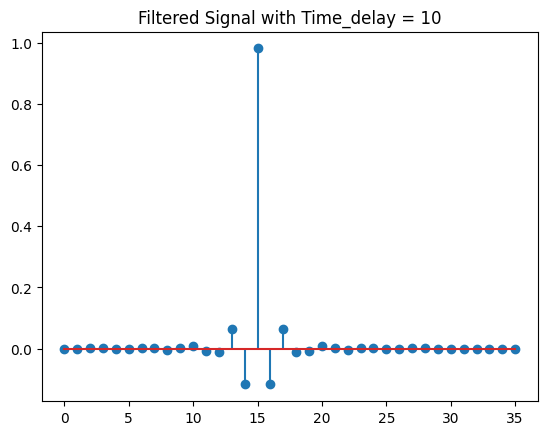

In [8]:
# upsampling

# Function to perform upsampling by a factor of r
def upsampling(inp, r):
    com_reshape = tf.reshape(inp, [-1, 1])
    padding = tf.constant([[0, 0], [0, r - 1]])
    upsampled = tf.pad(com_reshape, padding, mode="CONSTANT")
    upsampled = tf.reshape(upsampled, [-1])  # Flatten back to 1D
    return upsampled

# Function to perform upsampling on IQ signals
def upsample_iq(inp, r):
    real = inp[:, 0]  # Real part
    imag = inp[:, 1]  # Imaginary part

    # Upsample both real and imaginary parts
    real_up = upsampling(real, r)
    imag_up = upsampling(imag, r)

    # Combine the upsampled real and imaginary parts
    upsampled = tf.stack([real_up, imag_up], axis=1)
    return upsampled

# Function to do pulse shaping with NRRC code
import numpy as np
import tensorflow as tf
from scipy.signal import lfilter

# Function to create a normalized RRC filter
def rrc_filter(alpha, sps, num_taps, ts = 1):
    """
    Create a root-raised cosine (RRC) filter.

    Args:
        ts: Sampling period (default is 1).
        alpha: Roll-off factor (0 <= alpha <= 1).
        sps: Samples per symbol (upsampling factor).
        num_taps: Number of filter taps (should be odd).

    Returns:
        RRC filter coefficients.
    """
    t = np.linspace(-num_taps//2, num_taps//2 + 1,num_taps)
    rrc = np.zeros_like(t)

    for i in range(len(t)):
        if t[i] == 0.0:
            rrc[i] = (1.0 - alpha + 4 * alpha / np.pi)/ts
        elif np.abs(t[i]) == ts / (4 * alpha):
            rrc[i] = (alpha /( np.sqrt(2)*ts)) * \
                     ((1 + 2/np.pi) * np.sin(np.pi / (4 * alpha)) +
                      (1 - 2/np.pi) * np.cos(np.pi / (4 * alpha)))
        else:
            rrc[i] = (np.sin(np.pi * (t[i]/ts) * (1 - alpha)) +
                      4 * alpha * (t[i]/ts) * np.cos(np.pi * (t[i]/ts) * (1 + alpha))) / \
                     (np.pi * t[i] * (1 - (4 * alpha * (t[i]/ts))**2))

    # Normalize filter coefficients to ensure unit energy
    rrc = rrc / np.sqrt(np.sum(rrc**2))
    rrc = tf.constant(rrc, dtype=tf.float32)
    # plt.stem(t,rrc)  # Plot for visualization
    # plt.title(f"Time_delay = {10}")
    return rrc


# Function to apply upsampling and filtering using conv1d
def upsample_and_filter(signal, r, alpha, num_taps):
    # Upsample the signal
    upsampled_signal = upsample_iq(signal, r)

    # Create the RRC filter
    rrc = rrc_filter(alpha, r, num_taps)

    # Add a batch and channel dimension for conv1d
    upsampled_signal = tf.expand_dims(upsampled_signal, axis=0)  # Shape: (1, length, 2)
    rrc = tf.reshape(rrc, [-1, 1, 1])  # Shape: (filter_length, 1, 1)

    padding_size = num_taps//2
    paddings = tf.constant([[0, 0], [padding_size, padding_size], [0, 0]])
    padded_real = tf.pad(upsampled_signal[:, :, 0:1], paddings, "CONSTANT")
    padded_imag = tf.pad(upsampled_signal[:, :, 1:2], paddings, "CONSTANT")
    upsampled_signal = tf.concat([padded_real, padded_imag], axis=2)
    # Apply the RRC filter using conv1d
    real_filtered = tf.nn.conv1d(upsampled_signal[:, :, 0:1], rrc, stride=1, padding='SAME')
    imag_filtered = tf.nn.conv1d(upsampled_signal[:, :, 1:2], rrc, stride=1, padding='SAME')

    # Combine filtered real and imaginary parts
    filtered_signal = tf.concat([real_filtered, imag_filtered], axis=2)
    filtered_signal = tf.squeeze(filtered_signal, axis=0)  # Remove the batch dimension

    return filtered_signal

def time_offset(sampling_time = 10 ):
  t_offset = np.random.uniform(-sampling_time//2, sampling_time//2)
  return t_offset

# def signal_sample(received_signal,fs=1,s_rate = 10,num_taps

# def signal_sample(received_signal,fs=1,s_rate = 10,num_taps):
#     sampling_rate = s_rate*fs
#     signal_sample = received_signal[::sampling_rate]

#     x_axis = np.arange(-num_taps//2, num_taps//2 + 1) / s_rate
#     plt.stem(x_axis[:len(signal_sample)], signal_sample)  # Plot for visualization
#     plt.title(f"Time_delay = {10}")
#     return signal_sample


def pulse_shape_decode(received_signal, fs, alpha, num_taps):
    # fs  = sampling frequency
    # get the samples from received signal tapping


    return None



# Example usage:

# Define parameters
r = 6  # Upsampling factor
alpha = 0.35  # Roll-off factor
num_taps = 31  # Number of filter taps (should be odd)

# # Example input: Complex signal with real and imaginary parts
# input_signal = tf.constant([[1.0, -1.0]])

# # Apply upsampling and RRC filtering
# filtered_signal = upsample_and_filter(input_signal, r, alpha, num_taps)

# filtered_signal_real = filtered_signal[:, 0].numpy()
# # sampled_signal = signal_sample(filtered_signal_real,fs=1,s_rate = 10)


# # Generate x-axis data with matching length
# x_axis = np.arange(-num_taps//2, num_taps//2 + 1) / r

# plt.stem(x_axis[:len(filtered_signal_real)], filtered_signal_real)  # Plot for visualization
# plt.title(f"Time_delay = {10}")
# print("Filtered Signal:")
# print(len(filtered_signal))


# Example input: Complex signal with real and imaginary parts
input_signal = tf.constant([[1.0, -1.0]])  # Example input signal with 2 samples

print(f"Input signal length: {len(input_signal)}")

# Apply upsampling and RRC filtering
filtered_signal = upsample_and_filter(input_signal, r, alpha, num_taps)

# Print lengths
upsampled_signal_length = len(upsample_iq(input_signal, r))
expected_output_length = upsampled_signal_length + num_taps - 1

print(f"Expected output length: {expected_output_length}")
print(f"Actual filtered signal length: {len(filtered_signal)}")

# Visualize the filtered signal
filtered_signal_real = filtered_signal[:, 0].numpy()

# Generate x-axis data with matching length
x_axis = np.arange(len(filtered_signal_real))

plt.stem(x_axis, filtered_signal_real)  # Plot for visualization
plt.title(f"Filtered Signal with Time_delay = {10}")
plt.show()




<ipython-input-9-bd31ea977940>:127: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(np.arange(len(bitstream)), bitstream, 'b', markerfmt='bo', basefmt=" ", use_line_collection=True)


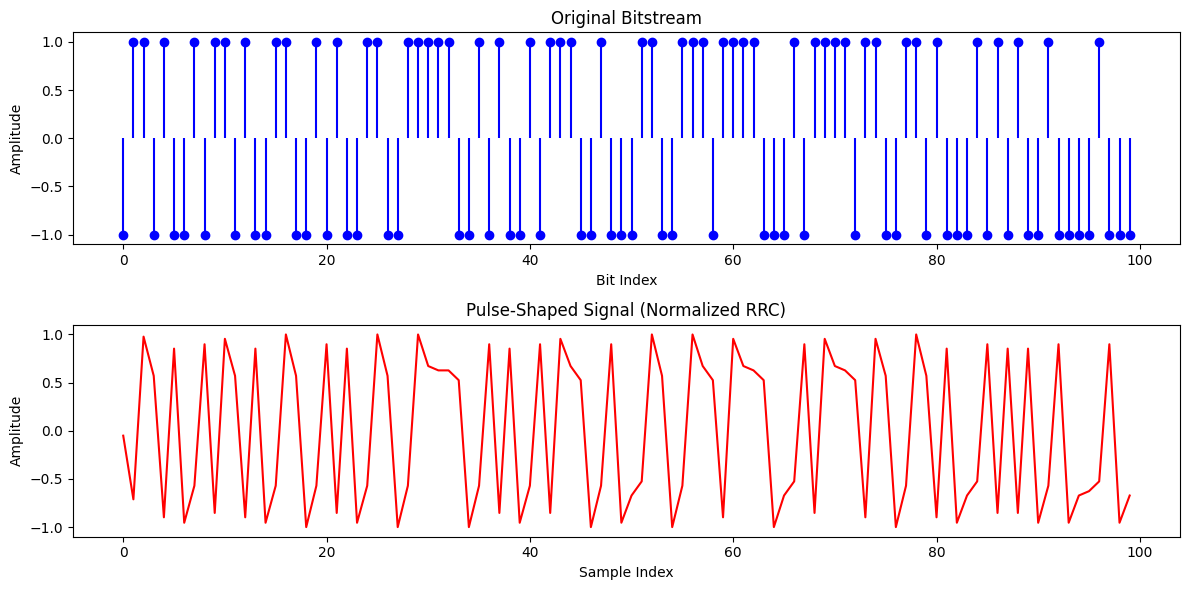

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

# function to create the complex values
def real_to_complex_tensor(inp_tensor):
  inp_tensor = tf.reshape(inp_tensor, [-1, 2])
  real_part = inp_tensor[:, 0]
  imag_part = inp_tensor[:, 1]
  complex_tensor = tf.complex(real_part, imag_part)
  return complex_tensor

def complex_to_real_tensor(inp_tensor):
   real_part , imag_part = tf.math.real(inp_tensor), tf.math.imag(inp_tensor)
   real_part = tf.reshape(real_part,[-1,1])
   imag_part = tf.reshape(imag_part,[-1,1])
   return tf.reshape(tf.concat([real_part,imag_part],1),[-1])

# RRC Filter Design
class NRRC_filter(tf.keras.layers.Layer):

  def __init__(self,beta,span,sps,input):
    super(NRRC_filter, self).__init__(**kwargs)
    self.beta = beta
    self.span = span
    self.sps = sps
    self.input = input

  def build(self,beta, span, sps):
        """
        Create a Root Raised Cosine (RRC) filter (FIR) impulse response.

        Parameters:
        beta : Roll-off factor (0 <= beta <= 1)
        span : Filter span in symbols
        sps : Samples per symbol

        Returns:
        h_rrc : RRC filter coefficients (impulse response)
        """
        t = np.linspace(-span / 2, span / 2, span * sps + 1)
        h_rrc = np.zeros_like(t)

        for i in range(len(t)):
            if t[i] == 0.0:
                h_rrc[i] = 1.0 - beta + (4 * beta / np.pi)
            elif abs(t[i]) == 1 / (4 * beta):
                h_rrc[i] = (beta / np.sqrt(2)) * (((1 + 2 / np.pi) * np.sin(np.pi / (4 * beta))) +
                                                  ((1 - 2 / np.pi) * np.cos(np.pi / (4 * beta))))
            else:
                h_rrc[i] = (np.sin(np.pi * t[i] * (1 - beta)) +
                            4 * beta * t[i] * np.cos(np.pi * t[i] * (1 + beta))) / \
                          (np.pi * t[i] * (1 - (4 * beta * t[i]) ** 2))

        # Normalize filter energy to 1
        h_rrc = h_rrc / np.sqrt(np.sum(h_rrc ** 2))
        return h_rrc

  def call(self, input):

      """
      Apply pulse shaping to a bitstream using a given filter.

      Parameters:
      bitstream : Input bitstream (BPSK symbols)
      h_rrc : RRC filter coefficients
      sps : Samples per symbol

      Returns:
      shaped_signal : Pulse-shaped signal
      """
      # Upsample the bitstream (insert zeros between symbols)
      upsampled = np.zeros(len(input) * sps)
      upsampled[::sps] = input

      # Convolve with the RRC filter
      shaped_signal = lfilter(h_rrc, 1.0, input)
      return shaped_signal

  def get_config(self):
      config = super(NRRC_filter, self).get_config()
      config.update({'beta': self.beta, 'span': self.span, 'sps': self.sps})
      return config
# Pulse Shaping
def pulse_shaping(bitstream, h_rrc, sps):
    """
    Apply pulse shaping to a bitstream using a given filter.

    Parameters:
    bitstream : Input bitstream (BPSK symbols)
    h_rrc : RRC filter coefficients
    sps : Samples per symbol

    Returns:
    shaped_signal : Pulse-shaped signal
    """
    # Upsample the bitstream (insert zeros between symbols)
    upsampled = np.zeros(len(bitstream) * sps)
    upsampled[::sps] = bitstream

    # Convolve with the RRC filter
    shaped_signal = lfilter(h_rrc, 1.0, bitstream)
    return shaped_signal

# Parameters
beta = 0.35  # Roll-off factor
span = 31    # Filter span (in symbols)
sps = 4      # Samples per symbol
num_bits = 100  # Number of bits

# Generate a random bitstream (BPSK symbols: -1, 1)
bitstream = 2 * np.random.randint(0, 2, num_bits) - 1

# Create the RRC filter
h_rrc = rrc_filter(beta, span, sps)

# Perform pulse shaping
shaped_signal = pulse_shaping(bitstream, h_rrc, sps)

# Normalize the shaped signal
shaped_signal /= np.max(np.abs(shaped_signal))

# Plot the original bitstream and the pulse-shaped signal
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.stem(np.arange(len(bitstream)), bitstream, 'b', markerfmt='bo', basefmt=" ", use_line_collection=True)
plt.title('Original Bitstream')
plt.xlabel('Bit Index')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(shaped_signal, 'r')
plt.title('Pulse-Shaped Signal (Normalized RRC)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


# implementation of AE with noise channel working.

In [4]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# import numpy as np
# import math
# import matplotlib.pyplot as plt

# Dataset Parameters
N = 4  # Number of channel uses
M = 16  # Number of total messages that can be transmitted
K = int(math.ceil(np.log2(M)))  # Block size
Eb_No = 10
batch_size = 320

# Create Dataset in one-hot vector
alphabet_size = pow(2, K)
alphabet = np.eye(alphabet_size, dtype='float32')

train_dataset = np.tile(alphabet, (batch_size, 1))
test_dataset = np.tile(alphabet, (batch_size * 10, 1))

# Normalization Layer
class Normalization(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Normalization, self).__init__(**kwargs)

    def call(self, input):
        shape = tf.shape(input)
        out = tf.nn.l2_normalize(tf.reshape(input, (-1, 2)), axis=-1, epsilon=1e-5)
        # out = tf.nn.l2_normalize(tf.reshape(input, (-1, 2*N)), axis=-1, epsilon=1e-5)                                # to normalize the power of symbol
        # out = tf.nn.l2_normalize(tf.reshape(input, (-1, shape[-1])), axis=-1, epsilon=1e-5)  # to normalize the power of all the signal
        out = tf.reshape(out, (-1,2*N))
        print(" Normalize each input power to 1 ")
        return out

    def get_config(self):
        return super(Normalization, self).get_config()

# Custom Noise Layer
class CustomNoise(tf.keras.layers.Layer):
    def __init__(self, mean=0.0, stddev=10**(-1.0*Eb_No), **kwargs):
        super(CustomNoise, self).__init__(**kwargs)
        self.mean = mean
        self.stddev = stddev

    def call(self, inputs):
        noise = tf.random.normal(shape=tf.shape(inputs), mean=self.mean, stddev=self.stddev)
        return inputs + noise

import tensorflow as tf
from tensorflow.keras.layers import Layer

class RealToComplexPair(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(RealToComplexPair, self).__init__(**kwargs)

    def call(self, inputs):
        # Get the inner dimension size
        inner_dimension = inputs.shape[-1] // 2  # Assuming the last dimension is even

        # Create indices for real and imaginary parts
        real_indices = tf.range(0, 2 * inner_dimension, 2)
        imag_indices = tf.range(1, 2 * inner_dimension, 2)

        # Extract real and imaginary parts using the indices
        real_part = tf.gather(inputs, real_indices, axis=-1)
        imag_part = tf.gather(inputs, imag_indices, axis=-1)

        # Combine the real and imaginary parts into a complex tensor
        complex_tensor = tf.complex(real_part, imag_part)
        return complex_tensor

    def compute_output_shape(self, input_shape):
        # Output shape will have half the last dimension (as complex numbers)
        return input_shape[:-1] + (input_shape[-1] // 2,)

    def get_config(self):
        config = super(RealToComplexPair, self).get_config()
        return config



class AE:
    def __init__(self, train_data=train_dataset, test_data=test_dataset, input_dim=K, enc_dim=N, act_fun='tanh'):
        self.train_data = train_data
        self.test_data = test_data
        self.input_dim = input_dim
        self.enc_dim = enc_dim
        self.act_fun = act_fun

    def AE_implement(self):
        autoencoder = Sequential([
            Dense(2**(self.input_dim), activation=self.act_fun, name="Input"),
            Dense(2**(self.input_dim), activation=self.act_fun, name="encoder"),
            Dense(2**(self.input_dim), activation=self.act_fun, name="middle1"),
            Dense(self.enc_dim * 2, activation=self.act_fun, name='middle2'),

            # Convert to complex tensor
            # RealToComplexPair(name = 'real2complex'),

            # Normalization Layer
            Normalization(name = 'normalization'),

            # Channel Layer
            # StochasticChannelv2(name = 'stc'),
            # NormalizedRRCFilterLayer( ),
            CustomNoise(name = 'noise'),

            # Decoder layers
            Dense(self.enc_dim * 4, activation=self.act_fun, name="decoder1"),
            Dense(2**(self.input_dim), activation=self.act_fun, name='decoder2'),
            Dense(2**(self.input_dim), activation='softmax', name='Output')
        ])

        autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return autoencoder

    def train(self, epochs=10, batch_size=32):
        autoencoder = self.AE_implement()
        autoencoder.fit(self.train_data, self.train_data,
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(self.test_data, self.test_data))
        return autoencoder

# Instantiate the AE class and train the model
ae = AE(train_data=train_dataset, test_data=test_dataset, input_dim=K, enc_dim=N, act_fun='relu')
autoencoder_model = ae.train(epochs=10, batch_size=batch_size)
print("This is the sample input dimension ",len(train_dataset[0]))
# Evaluate the model on the test data
loss, accuracy = autoencoder_model.evaluate(test_dataset, test_dataset)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


Epoch 1/10
 Normalize each input power to 1 
 Normalize each input power to 1 
 Normalize each input power to 1 
 1/16 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.0000e+00 - loss: 2.7889 Normalize each input power to 1 
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.0069 - loss: 2.7627 - val_accuracy: 0.0625 - val_loss: 2.6562
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1106 - loss: 2.6263 - val_accuracy: 0.2500 - val_loss: 2.5573
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2531 - loss: 2.5340 - val_accuracy: 0.3750 - val_loss: 2.4578
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3773 - loss: 2.4320 - val_accuracy: 0.4375 - val_loss: 2.3434
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4589 - loss: 2.3097 - val_accuracy: 0.5000 - val_loss: 2.2128
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4977 - loss: 2.1820 - val_accuracy: 0.5625 - val_loss: 2.0714
Epoch 7/10
16/16 ━━━━━━━━━

In [6]:
autoencoder_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (Dense)                        │ (320, 16)                   │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Dense)                      │ (320, 16)                   │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ middle1 (Dense)                      │ (320, 16)                   │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ middle2 (Dense)                      │ (320, 8)                    │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (320, 8)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ noise (CustomNoise)                  │ (320, 8)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder1 (Dense)                     │ (320, 16)                   │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder2 (Dense)                     │ (320, 16)                   │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (320, 16)                   │             272 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,922 (19.23 KB)

 Trainable params: 1,640 (6.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,282 (12.82 KB)

# Stochastic Channel layer

In [11]:
# Custom Noise Layer
class CustomNoise(tf.keras.layers.Layer):
    def __init__(self, mean=0.0, stddev=10**(-1.0*Eb_No), **kwargs):
        super(CustomNoise, self).__init__(**kwargs)
        self.mean = mean
        self.stddev = stddev

    def call(self, inputs):
        noise = tf.random.normal(shape=tf.shape(inputs), mean=self.mean, stddev=self.stddev)
        return inputs + noise

class StochasticChannel(tf.keras.layers.Layer):
    def __init__(self, roll_off=0.35, num_taps=101, time_delay=0, rate=1, **kwargs):
        super(StochasticChannelv2, self).__init__(**kwargs)
        self.num_taps = num_taps
        self.time_delay = time_delay
        self.rate = rate
        self.roll_off = roll_off
        # self.Noise_layer  = CustomNoise(mean=0.0,stddev=channel_parameters['noise_std'])

    def upsampling(self, input):
        input = tf.reshape(input, [-1, 1])
        padding = tf.constant([[0, 0], [0, self.rate - 1]])
        upsampled = tf.pad(input, padding, "CONSTANT")
        print("shape after upsamping:", input.shape)
        return tf.reshape(upsampled, [-1])

    def upsample_iq(self, input):
        inner_dimension = ( input.shape[1])
        N = inner_dimension//2
        Real, Imag = [],[]
        for i in range(N):
          real_t,imag_t = input[:,2*i],input[:,2*i+1]
          Real.extend(real_t)
          Imag.concat(imag_t)
        input = tf.stack([Real, Imag], axis=1)


        # # Create indices for real and imaginary parts
        # real_indices = tf.range(0, inner_dimension-1, 2)
        # imag_indices = tf.range(1, inner_dimension, 2)

        # # # Extract real and imaginary parts using the indices
        # # real_part = tf.gather(input[:], real_indices, axis=-1)
        # # imag_part = tf.gather(input[:], imag_indices, axis=-1)

        # # Convert indices to numpy for slicing
        # real_indices = real_indices.numpy()
        # imag_indices = imag_indices.numpy()

        # real = input[:, real_indices]
        # imag = input[:, imag_indices]
        print("input dimension:", input.shape)
        real_up = self.upsampling(real)
        imag_up = self.upsampling(imag)
        return tf.stack([real_up, imag_up], axis=1)

    def rrc_filter(self):
        """
        Create a root-raised cosine (RRC) filter.

        Returns:
            RRC filter coefficients.
        """
        t = np.linspace(-self.num_taps // 2, self.num_taps // 2, self.num_taps)
        rrc = np.zeros_like(t)

        for i in range(len(t)):
            if t[i] == 0.0:
                rrc[i] = (1.0 - self.roll_off + 4 * self.roll_off / np.pi)
            elif np.abs(t[i]) == 1 / (4 * self.roll_off):
                rrc[i] = (self.roll_off / (np.sqrt(2))) * \
                         ((1 + 2 / np.pi) * np.sin(np.pi / (4 * self.roll_off)) +
                          (1 - 2 / np.pi) * np.cos(np.pi / (4 * self.roll_off)))
            else:
                rrc[i] = (np.sin(np.pi * (t[i]) * (1 - self.roll_off)) +
                          4 * self.roll_off * (t[i]) * np.cos(np.pi * (t[i]) * (1 + self.roll_off))) / \
                         (np.pi * t[i] * (1 - (4 * self.roll_off * (t[i])) ** 2))

        # Normalize filter coefficients to ensure unit energy
        rrc = rrc / np.sqrt(np.sum(rrc ** 2))
        rrc = tf.constant(rrc, dtype=tf.float32)
        return rrc

    def upsample_and_filter(self, input):
        # Reshape the input dimension
        # input = tf.reshape(input, [-1, 2])

        # Upsample the signal
        upsampled_signal = self.upsample_iq(input)

        # Create the RRC filter
        rrc = self.rrc_filter()

        # Add a batch and channel dimension for conv1d
        upsampled_signal = tf.expand_dims(upsampled_signal, axis=0)  # Shape: (1, length, 2)
        rrc = tf.reshape(rrc, [-1, 1, 1])  # Shape: (filter_length, 1, 1)

        padding_size = self.num_taps // 2
        paddings = tf.constant([[0, 0], [padding_size, padding_size], [0, 0]])
        padded_real = tf.pad(upsampled_signal[:, :, 0:1], paddings, "CONSTANT")
        padded_imag = tf.pad(upsampled_signal[:, :, 1:2], paddings, "CONSTANT")
        padded_signal = tf.concat([padded_real, padded_imag], axis=2)

        # Apply the RRC filter using conv1d
        real_filtered = tf.nn.conv1d(padded_signal[:, :, 0:1], rrc, stride=1, padding='VALID')
        imag_filtered = tf.nn.conv1d(padded_signal[:, :, 1:2], rrc, stride=1, padding='VALID')

        # Combine filtered real and imaginary parts
        filtered_signal = tf.concat([real_filtered, imag_filtered], axis=2)
        print("input shape; ",input.shape)
        print("shape after filtering:", filtered_signal.shape)
        filtered_signal = tf.squeeze(filtered_signal, axis=0)  # Remove the batch dimension
        print("shape after squeeze:", filtered_signal[0])

        return filtered_signal

    def call(self, inputs):
        # Apply upsampling and RRC filtering
        filtered_signal = self.upsample_and_filter(inputs)

        # Log the filtered signal for TensorBoard visualization
        with tf.summary.create_file_writer('logs/stochastic_channel').as_default():
            tf.summary.histogram("Filtered Signal", filtered_signal, step=0)

        return filtered_signal

# partially working stochastic channel


In [12]:
input_layer = autoencoder_model.get_layer('Input')
before_channel = Model(inputs=input_layer.input,  # Use KerasTensor as input
                       outputs=autoencoder_model.get_layer('normalization').output)
enc = before_channel(train_dataset)
# tf.Tensor(
# [1.        0.        0.        1.        0.7818562 0.6234588 0.
# 0.       ], shape=(8,), dtype=float32)


# Function to create a normalized RRC filter
def rrc_filter(alpha=.35, sps=1, num_taps=15, ts = 1):
    """
    Create a root-raised cosine (RRC) filter.

    Args:
        ts: Sampling period (default is 1).
        alpha: Roll-off factor (0 <= alpha <= 1).
        sps: Samples per symbol (upsampling factor).
        num_taps: Number of filter taps (should be odd).

    Returns:
        RRC filter coefficients.
    """
    t = np.linspace(-num_taps//2, num_taps//2 + 1,num_taps)
    rrc = np.zeros_like(t)

    for i in range(len(t)):
        if t[i] == 0.0:
            rrc[i] = (1.0 - alpha + 4 * alpha / np.pi)/ts
        elif np.abs(t[i]) == ts / (4 * alpha):
            rrc[i] = (alpha /( np.sqrt(2)*ts)) * \
                     ((1 + 2/np.pi) * np.sin(np.pi / (4 * alpha)) +
                      (1 - 2/np.pi) * np.cos(np.pi / (4 * alpha)))
        else:
            rrc[i] = (np.sin(np.pi * (t[i]/ts) * (1 - alpha)) +
                      4 * alpha * (t[i]/ts) * np.cos(np.pi * (t[i]/ts) * (1 + alpha))) / \
                     (np.pi * t[i] * (1 - (4 * alpha * (t[i]/ts))**2))

    # Normalize filter coefficients to ensure unit energy
    rrc = rrc / np.sqrt(np.sum(rrc**2))
    rrc = tf.constant(rrc, dtype=tf.float32)
    # plt.stem(t,rrc)  # Plot for visualization
    # plt.title(f"Time_delay = {10}")
    return rrc

# print(enc[0])

def real_to_complex_tensor(inp_tensor):
    # Reshape the tensor to group adjacent real and imaginary parts
    batch_size = inp_tensor.shape[0]   # Number of batches
    inner_dim = inp_tensor.shape[1]    # Inner dimension size

    # Ensure that the inner dimension is even (for real and imaginary pairs)
    assert inner_dim % 2 == 0, "Inner dimension must be even for real and imaginary pairs."

    # Reshape the tensor to separate real and imaginary parts
    reshaped_tensor = tf.reshape(inp_tensor, [batch_size, inner_dim // 2, 2])

    rrc = rrc_filter()
    rrc = tf.reshape(rrc, [-1, 1, 1])  # Shape: (filter_length, 1, 1) for conv1d

    # Extract real and imaginary parts
    real_part = reshaped_tensor[:, :, 0]
    real_part = upsample(real_part, 4)

    imag_part = reshaped_tensor[:, :, 1]
    imag_part = upsample(imag_part, 4)

    # Add a channel dimension to match conv1d's 3D input requirement
    real_part = tf.expand_dims(real_part, axis=-1)  # Shape: (batch_size, time_length, 1)
    imag_part = tf.expand_dims(imag_part, axis=-1)  # Shape: (batch_size, time_length, 1)

    # Apply the RRC filter using conv1d (expects [batch_size, width, channels])
    real_filtered = tf.nn.conv1d(real_part, rrc, stride=1, padding='VALID')
    imag_filtered = tf.nn.conv1d(imag_part, rrc, stride=1, padding='VALID')

    real_filtered = tf.squeeze(real_filtered, axis=-1)  # Shape: (batch_size, time_length)
    imag_filtered = tf.squeeze(imag_filtered, axis=-1)  # Shape: (batch_size, time_length)

    # Interleave real and imaginary parts
    interleaved = tf.stack([real_filtered, imag_filtered], axis=-1)  # Shape: (batch_size, time_length, 2)
    interleaved = tf.reshape(interleaved, [batch_size, -1])  # Flatten to (batch_size, time_length*2)

    return interleaved


# Test input tensor (e.g., batch of 2 samples with 4 real values each)
# For example, real values are [1, 2, 3, 4], to be grouped as (1+2j, 3+4j)
# enc = tf.constant([[1, 2, 3, 4], [5, 6, 7, 8]], dtype=tf.float32)
def upsample(input_tensor, r=2):
    """
    Function to upsample a tensor by adding r-1 zeros between each element along the last axis.
    """
    # Expand dimensions of the input to insert the zeros
    input_shape = tf.shape(input_tensor)
    expanded_input = tf.expand_dims(input_tensor, axis=-1)  # Add an extra dimension

    # Create a tensor of zeros with the same shape as input, but r times the last dimension
    zero_padding = tf.zeros_like(expanded_input)  # Tensor of zeros
    zero_padding = tf.tile(zero_padding, [1, 1, r-1])  # Repeat the zeros r-1 times

    # Concatenate input and zero_padding along the last dimension
    upsampled = tf.concat([expanded_input, zero_padding], axis=-1)

    # Reshape to flatten the added dimension
    new_shape = [input_shape[0], input_shape[1] * r]
    upsampled_flat = tf.reshape(upsampled, new_shape)
    return upsampled_flat
"""-------------------------------------------------------------------------------------------------------------------------------Creating Layer -----------------------"""
class StochasticChannelv2(tf.keras.layers.Layer):
    def __init__(self, roll_off=0.35, num_taps=3, time_delay=0, rate=1, ts=1, **kwargs):
        super(StochasticChannelv2, self).__init__(**kwargs)
        self.num_taps = num_taps
        self.time_delay = time_delay
        self.rate = rate
        self.roll_off = roll_off
        self.ts = ts  # Define ts (sampling period) as an instance attribute

    def upsample(self, input_tensor):
        """
        Function to upsample a tensor by adding (rate - 1) zeros between each element along the last axis.
        """
        # Expand dimensions of the input to insert the zeros
        input_shape = tf.shape(input_tensor)
        expanded_input = tf.expand_dims(input_tensor, axis=-1)  # Add an extra dimension

        # Create a tensor of zeros with the same shape as input, but rate times the last dimension
        zero_padding = tf.zeros_like(expanded_input)  # Tensor of zeros
        zero_padding = tf.tile(zero_padding, [1, 1, self.rate - 1])  # Repeat the zeros rate-1 times

        # Concatenate input and zero_padding along the last dimension
        upsampled = tf.concat([expanded_input, zero_padding], axis=-1)

        # Reshape to flatten the added dimension
        new_shape = [input_shape[0], input_shape[1] * self.rate]
        upsampled_flat = tf.reshape(upsampled, new_shape)
        return upsampled_flat

    def real_to_complex_tensor(self, inp_tensor):
        # Reshape the tensor to group adjacent real and imaginary parts
        batch_size = inp_tensor.shape[0]   # Number of batches
        inner_dim = inp_tensor.shape[1]    # Inner dimension size

        # Ensure that the inner dimension is even (for real and imaginary pairs)
        assert inner_dim % 2 == 0, "Inner dimension must be even for real and imaginary pairs."

        # Reshape the tensor to separate real and imaginary parts
        reshaped_tensor = tf.reshape(inp_tensor, [batch_size, inner_dim // 2, 2])

        rrc = self.rrc_filter()
        rrc = tf.reshape(rrc, [-1, 1, 1])  # Shape: (filter_length, 1, 1) for conv1d

        # Extract real and imaginary parts
        real_part = reshaped_tensor[:, :, 0]
        real_part = self.upsample(real_part)  # Use self.upsample

        imag_part = reshaped_tensor[:, :, 1]
        imag_part = self.upsample(imag_part)  # Use self.upsample

        # Add a channel dimension to match conv1d's 3D input requirement
        real_part = tf.expand_dims(real_part, axis=-1)  # Shape: (batch_size, time_length, 1)
        imag_part = tf.expand_dims(imag_part, axis=-1)  # Shape: (batch_size, time_length, 1)

        # Apply the RRC filter using conv1d (expects [batch_size, width, channels])
        real_filtered = tf.nn.conv1d(real_part, rrc, stride=1, padding='VALID')
        imag_filtered = tf.nn.conv1d(imag_part, rrc, stride=1, padding='VALID')

        real_filtered = tf.squeeze(real_filtered, axis=-1)  # Shape: (batch_size, time_length)
        imag_filtered = tf.squeeze(imag_filtered, axis=-1)  # Shape: (batch_size, time_length)

        # Interleave real and imaginary parts
        interleaved = tf.stack([real_filtered, imag_filtered], axis=-1)  # Shape: (batch_size, time_length, 2)
        interleaved = tf.reshape(interleaved, [batch_size, -1])  # Flatten to (batch_size, time_length*2)

        return interleaved

    # Function to create a normalized RRC filter
    def rrc_filter(self):
        """
        Create a root-raised cosine (RRC) filter.
        """
        t = np.linspace(-self.num_taps // 2, self.num_taps // 2 + 1, self.num_taps)
        rrc = np.zeros_like(t)

        for i in range(len(t)):
            if t[i] == 0.0:
                rrc[i] = (1.0 - self.roll_off + 4 * self.roll_off / np.pi) / self.ts
            elif np.abs(t[i]) == self.ts / (4 * self.roll_off):
                rrc[i] = (self.roll_off / (np.sqrt(2) * self.ts)) * \
                         ((1 + 2 / np.pi) * np.sin(np.pi / (4 * self.roll_off)) +
                          (1 - 2 / np.pi) * np.cos(np.pi / (4 * self.roll_off)))
            else:
                rrc[i] = (np.sin(np.pi * (t[i] / self.ts) * (1 - self.roll_off)) +
                          4 * self.roll_off * (t[i] / self.ts) * np.cos(np.pi * (t[i] / self.ts) * (1 + self.roll_off))) / \
                         (np.pi * t[i] * (1 - (4 * self.roll_off * (t[i] / self.ts)) ** 2))

        # Normalize filter coefficients to ensure unit energy
        rrc = rrc / np.sqrt(np.sum(rrc ** 2))
        rrc = tf.constant(rrc, dtype=tf.float32)
        return rrc

    def call(self, inputs):
        # Apply upsampling and RRC filtering
        upsampled_signal = self.upsample(inputs)
        output = self.real_to_complex_tensor(upsampled_signal)  # Use self.real_to_complex_tensor here
        return output



# Convert real to complex tensor
x = real_to_complex_tensor(enc)
y = StochasticChannelv2().real_to_complex_tensor(enc)
print(x.shape)
print(y)
print(enc.shape)
print("-------------------------------------------------------------")
print(y.shape)   # this will print the output of single data

 Normalize each input power to 1 
(5120, 4)
tf.Tensor(
[[1.0492855  0.05199245 1.0492855  0.05199245]
 [0.56485647 0.9330787  0.0804375  1.0463485 ]
 [0.99221194 0.20452815 0.10372001 1.0025347 ]
 ...
 [0.03335032 1.0371801  0.6397091  0.869077  ]
 [0.05441834 1.0492289  0.09852457 1.0481993 ]
 [1.0492855  0.05199245 1.0492854  0.05199245]], shape=(5120, 4), dtype=float32)
(5120, 8)
-------------------------------------------------------------
(5120, 4)


In [23]:
import tensorflow as tf

class StochasticChannel(tf.keras.layers.Layer):
    def __init__(self, roll_off=0.35, num_taps=101, time_delay=0, rate=1, **kwargs):
        super(StochasticChannel, self).__init__(**kwargs)
        self.num_taps = num_taps
        self.time_delay = time_delay
        self.rate = rate
        self.roll_off = roll_off

    def call(self, inputs):
        # Call the real_to_complex_tensor method and return the result
        return self.real_to_complex_tensor(inputs)

# Assuming `enc` is your input tensor
stochastic_channel = StochasticChannel(rate=2, roll_off=0.35, num_taps=101)
y = real_to_complex_tensor(enc)
print((y))


tf.Tensor(
[[-1.4426672e-01 -5.6373188e-04  9.6574003e-01 -8.6529534e-03]
 [-4.7915382e-05 -1.4274582e-01 -1.3386979e-02  9.6622872e-01]
 [ 1.2716351e-03 -1.4566153e-01 -1.7261822e-02  9.7352058e-01]
 ...
 [-9.5491521e-02 -1.1291277e-01  6.2501991e-01  7.3021793e-01]
 [-7.5097363e-03 -1.4410459e-01  3.6810681e-02  9.6467876e-01]
 [-1.4426672e-01 -5.6373188e-04  9.6573991e-01 -8.6529534e-03]], shape=(5120, 4), dtype=float32)


In [17]:
!pip install scikit-commpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-commpy: filename=scikit_commpy-0.8.0-py3-none-any.whl size=115007 sha256=d0ea5742d4c207dc7e35ac7b452fa46eea658201c091db366c5d2c3c52c822b3
  Stored in directory: /root/.cache/pip/wheels/36/eb/56/f0bffa07ed968244dac624cfc6dee75474b7b451299bf54950
Successfully built scikit-commpy


Input signal shape: (5120, 8)
Filtered signal shape: (5120, 108)
Expected shape: (5120, 108)


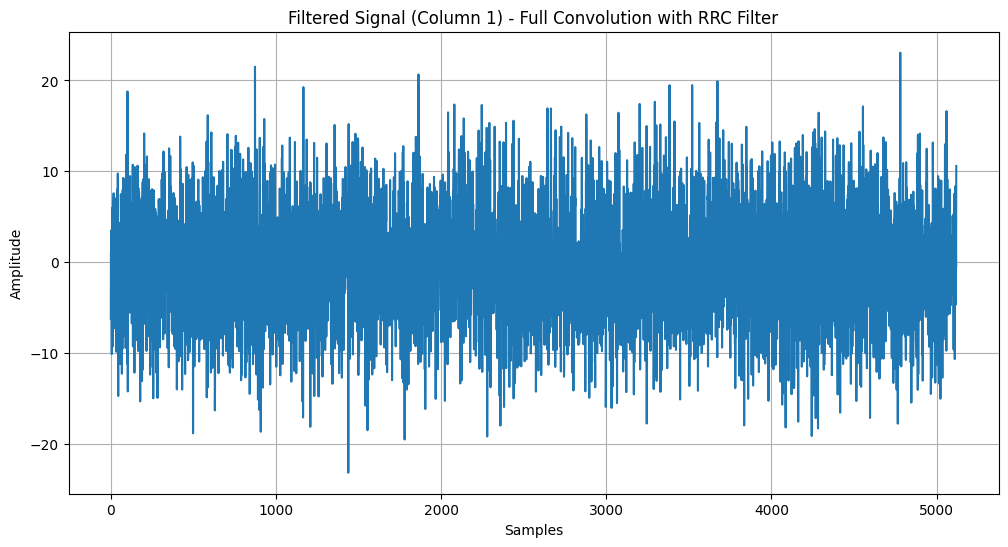

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from commpy.filters import rrcosfilter
from scipy.signal import convolve

# Define parameters for the RRC filter
alpha = 0.35  # Roll-off factor
sps = 8       # Samples per symbol (oversampling factor)
num_taps = 101  # Number of filter taps (should be odd)
Ts = 1        # Symbol period

# Generate the RRC filter
taps, t = rrcosfilter(num_taps, alpha, Ts, sps)

# Generate a random signal with shape (5120, 8) or use your signal here
signal = np.random.randn(5120, 8)  # Example: random signal

# Initialize a matrix to hold the filtered signal output
filtered_signal = np.zeros((signal.shape[0], signal.shape[1]+ num_taps - 1))

# Apply the RRC filter to each column (i.e., each signal channel)
for i in range(signal.shape[0]):
    filtered_signal[i,:] = convolve(signal[i,:], taps, mode='full')

# Check the dimensions of the filtered signal
print(f"Input signal shape: {signal.shape}")
print(f"Filtered signal shape: {filtered_signal.shape}")
print(f"Expected shape: {(signal.shape[0] , signal.shape[1]+ len(taps) - 1)}")

# Plotting the first column of the filtered signal for visualization
plt.figure(figsize=(12, 6))
plt.plot(filtered_signal[:,0])
plt.title("Filtered Signal (Column 1) - Full Convolution with RRC Filter")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [41]:
import tensorflow as tf
import numpy as np
from scipy.signal import convolve
from commpy.filters import rrcosfilter

import tensorflow as tf
from commpy.filters import rrcosfilter

class NormalizedRRCFilterLayer(tf.keras.layers.Layer):
    def __init__(self, alpha=0.35, sps=1, num_taps=101, ts=1, upsample_factor=4):
        """
        Initialize the layer with RRC filter parameters and upsampling factor.

        Args:
            alpha: Roll-off factor (0 <= alpha <= 1).
            sps: Samples per symbol (upsampling factor).
            num_taps: Number of filter taps (should be odd).
            ts: Sampling period (default is 1).
            upsample_factor: The factor by which to upsample the input signals.
        """
        super(NormalizedRRCFilterLayer, self).__init__()
        self.alpha = alpha
        self.sps = sps
        self.num_taps = num_taps
        self.ts = ts
        self.upsample_factor = upsample_factor

        # Create the RRC filter when the layer is initialized
        self.rrc_taps, _ = self.create_rrc_filter()

    def create_rrc_filter(self):
        """Generate the RRC filter coefficients using commpy."""
        taps, _ = rrcosfilter(self.num_taps, self.alpha, self.ts, self.sps)
        taps = tf.convert_to_tensor(taps, dtype=tf.float32)
        return taps, _

    def upsample(self, input_tensor):
        """Upsample the input tensor by inserting r-1 zeros between each element."""
        input_shape = tf.shape(input_tensor)
        expanded_input = tf.expand_dims(input_tensor, axis=-1)  # Add an extra dimension

        # Create a tensor of zeros with the same shape as input, but r times the last dimension
        zero_padding = tf.zeros_like(expanded_input)
        zero_padding = tf.tile(zero_padding, [1, 1, self.upsample_factor-1])  # Repeat the zeros r-1 times

        # Concatenate input and zero_padding along the last dimension
        upsampled = tf.concat([expanded_input, zero_padding], axis=-1)

        # Reshape to flatten the added dimension
        new_shape = [input_shape[0], input_shape[1] * self.upsample_factor]
        upsampled_flat = tf.reshape(upsampled, new_shape)
        return upsampled_flat

    def call(self, inputs):
        """Forward pass for the layer, converting real to complex and applying RRC filter."""
        batch_size = tf.shape(inputs)[0]  # Batch size
        inner_dim = tf.shape(inputs)[1]   # Inner dimension size
        print( inner_dim, batch_size)
        # Ensure that the inner dimension is even
        # assert inner_dim % 2 == 0, "Inner dimension must be even for real and imaginary pairs."

        # Reshape the input tensor to separate real and imaginary parts
        reshaped_tensor = tf.reshape(inputs, [batch_size, inner_dim // 2, 2])

        # Extract real and imaginary parts
        real_part = reshaped_tensor[:, :, 0]
        imag_part = reshaped_tensor[:, :, 1]

        # Upsample real and imaginary parts
        real_part = self.upsample(real_part)
        imag_part = self.upsample(imag_part)

        # Reshape taps for 1D convolution
        rrc_taps = tf.reshape(self.rrc_taps, [-1, 1, 1])  # Shape: (filter_length, 1, 1)

        # Add an extra dimension to real and imaginary parts for conv1d
        real_part = tf.expand_dims(real_part, axis=-1)
        imag_part = tf.expand_dims(imag_part, axis=-1)

        # Apply the RRC filter using TensorFlow's conv1d
        real_filtered = tf.nn.conv1d( rrc_taps,real_part, stride=1, padding='VALID')
        imag_filtered = tf.nn.conv1d( rrc_taps,imag_part, stride=1, padding='VALID')

        # Remove the extra dimension
        real_filtered = tf.squeeze(real_filtered, axis=-1)
        imag_filtered = tf.squeeze(imag_filtered, axis=-1)

        # Interleave real and imaginary parts
        interleaved = tf.stack([real_filtered, imag_filtered], axis=-1)  # Shape: (batch_size, time_length, 2)
        interleaved = tf.reshape(interleaved, [batch_size, -1])  # Flatten to (batch_size, time_length*2)

        return interleaved


class NormalizedRRCFilterLayer_v2(tf.keras.layers.Layer):
    def __init__(self, alpha=0.35, sps=1, num_taps=101, ts=1, upsample_factor=4):
        """
        Initialize the layer with RRC filter parameters and upsampling factor.

        Args:
            alpha: Roll-off factor (0 <= alpha <= 1).
            sps: Samples per symbol (upsampling factor).
            num_taps: Number of filter taps (should be odd).
            ts: Sampling period (default is 1).
            upsample_factor: The factor by which to upsample the input signals.
        """
        super(NormalizedRRCFilterLayer_v2, self).__init__()
        self.alpha = alpha
        self.sps = sps
        self.num_taps = num_taps
        self.ts = ts
        self.upsample_factor = upsample_factor

        # Create the RRC filter when the layer is initialized
        self.rrc_taps, _ = self.create_rrc_filter()

    def create_rrc_filter(self):
        """Generate the RRC filter coefficients using commpy."""
        taps, _ = rrcosfilter(self.num_taps, self.alpha, self.ts, self.sps)
        return taps, _

    def upsample(self, input_tensor):
        """Upsample the input tensor by inserting r-1 zeros between each element."""
        input_shape = tf.shape(input_tensor)
        expanded_input = tf.expand_dims(input_tensor, axis=-1)  # Add an extra dimension

        # Create a tensor of zeros with the same shape as input, but r times the last dimension
        zero_padding = tf.zeros_like(expanded_input)
        zero_padding = tf.tile(zero_padding, [1, 1, self.upsample_factor-1])  # Repeat the zeros r-1 times

        # Concatenate input and zero_padding along the last dimension
        upsampled = tf.concat([expanded_input, zero_padding], axis=-1)

        # Reshape to flatten the added dimension
        new_shape = [input_shape[0], input_shape[1] * self.upsample_factor]
        upsampled_flat = tf.reshape(upsampled, new_shape)
        return upsampled_flat

    def call(self, inputs):
        """Forward pass for the layer, converting real to complex and applying RRC filter."""
        batch_size = tf.shape(inputs)[0]  # Batch size
        inner_dim = tf.shape(inputs)[1]   # Inner dimension size
        print( inner_dim, batch_size)
        # Ensure that the inner dimension is even
        # assert inner_dim % 2 == 0, "Inner dimension must be even for real and imaginary pairs."

        # Reshape the input tensor to separate real and imaginary parts
        reshaped_tensor = tf.reshape(inputs, [batch_size, inner_dim // 2, 2])

        # Extract real and imaginary parts
        real_part = reshaped_tensor[:, :, 0]
        imag_part = reshaped_tensor[:, :, 1]

        # Upsample real and imaginary parts
        real_part = self.upsample(real_part)
        imag_part = self.upsample(imag_part)

        # Convert tensors to NumPy arrays for filtering
        real_part_np = real_part.numpy()
        imag_part_np = imag_part.numpy()

        # Apply the RRC filter using scipy's convolve
        real_filtered_np = np.array([convolve(real_part_np[i], self.rrc_taps, mode='full') for i in range(real_part_np.shape[0])])
        imag_filtered_np = np.array([convolve(imag_part_np[i], self.rrc_taps, mode='full') for i in range(imag_part_np.shape[0])])

        # Convert the filtered signals back to TensorFlow tensors
        real_filtered = tf.convert_to_tensor(real_filtered_np, dtype=tf.float32)
        imag_filtered = tf.convert_to_tensor(imag_filtered_np, dtype=tf.float32)

        # Interleave real and imaginary parts
        interleaved = tf.stack([real_filtered, imag_filtered], axis=-1)  # Shape: (batch_size, time_length, 2)
        interleaved = tf.reshape(interleaved, [batch_size, -1])  # Flatten to (batch_size, time_length*2)

        return interleaved


 Normalize each input power to 1 
tf.Tensor(8, shape=(), dtype=int32) tf.Tensor(5120, shape=(), dtype=int32)
Output shape: (5120, 232)


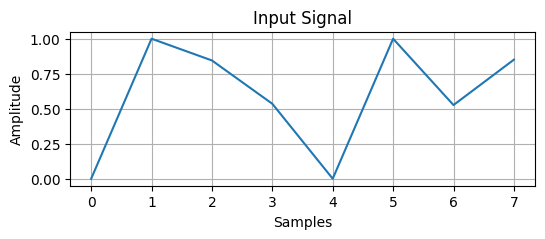

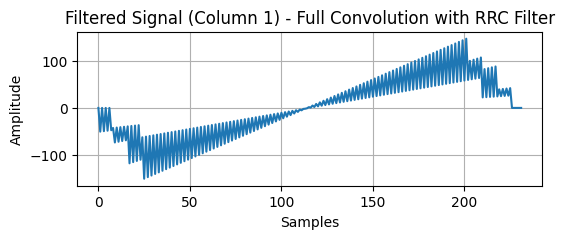

In [48]:

# Initialize the RRC filter layer
normalized_rrc_layer = NormalizedRRCFilterLayer_v2()
enc = before_channel(train_dataset)
# Apply the layer to the test input
output = normalized_rrc_layer(enc)

# Check the output shape and print it
print("Output shape:", output.shape)
# Plotting the first column of the filtered signal for visualization
plt.figure(figsize=(6, 2))
plt.plot(enc[10,:])
plt.title("Input Signal")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()
# Plotting the first column of the filtered signal for visualization
plt.figure(figsize=(6, 2))
plt.plot(output[10,:])
plt.title("Filtered Signal (Column 1) - Full Convolution with RRC Filter")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()